In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt
import time

import utils
import plot
import metrics

from svgd import SVGD, get_bandwidth

rkey = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Experiment 1: one-dim Gaussian mixture

## Experiment 1.1
Target distribution:
$$ p(x) = \mathcal N(x; 0, 1) $$
Initialization:
$$ q_0(x) = \mathcal N(x; -10, 1) $$
Kernel bandwidth:
$$ h = \text{med}^2 / \log n, $$
where med is the median of the $ n \choose 2$ pairwise distances between the points $x_1, \dots, x_n$. Important to note: the bandwidth here changes adaptively across iterations.

In [2]:
from jax.scipy.stats import norm

dist11 = metrics.Gaussian(0, 1)

n = 100
d = 1
stepsize = 0.01
L = 300
svgd_adaptive11 = SVGD(dist11, n_iter_max=L, adaptive_kernel=True, get_bandwidth=get_bandwidth, particle_shape=(n, d))

In [3]:
st = time.time()
xout11, log11 = svgd_adaptive11.svgd(svgd_adaptive11.rkey, stepsize, bandwidth=0, n_iter=L)
xout11.block_until_ready()
end = time.time()
print("Done computing in ", end - st, "seconds")

JIT COMPILING svgd...
...done compiling svgd after 0.546119213104248 seconds.
Done computing in  4.677060604095459 seconds


In [6]:
log11["desc"].keys()

dict_keys(['bandwidth', 'particle_mean', 'particle_var'])

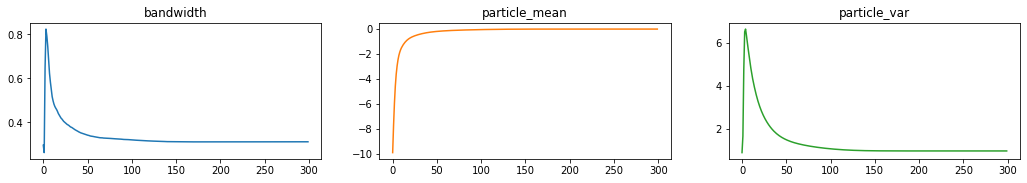

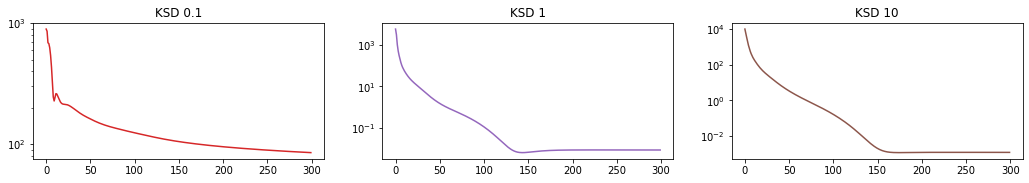

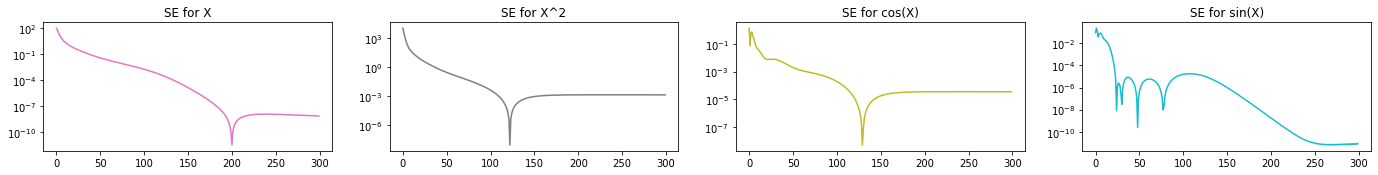

In [5]:
plot.svgd_log(log11)

In [7]:
log11["metrics"]["square_errors"][-1:]

DeviceArray([[[6.7979884e-09],
              [1.3632016e-03],
              [3.5406447e-05],
              [8.9529807e-12]]], dtype=float32)

## Experiment 1.2
Target distribution:
$$ p(x) = 1/3 \mathcal N(-2, 1) + 2/3 \mathcal N(2, 1) $$
Initialization:
$$ q_0(x) = \mathcal N(-10, 1) $$
Kernel bandwidth:
$$ h = \text{med}^2 / \log n, $$
where med is the median of the $ n \choose 2$ pairwise distances between the points $x_1, \dots, x_n$. Important to note: the bandwidth here changes adaptively across iterations.

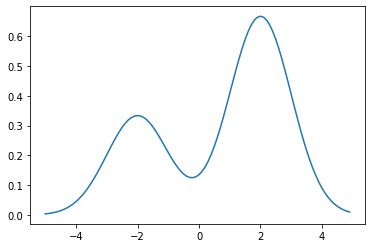

In [8]:
dist12 = metrics.GaussianMixture([-2, 2], [1, 1], [1/3, 2/3])

grid = np.arange(-5, 5, 0.1)
_ = plt.plot(grid, np.exp(vmap(dist12.logpdf)(grid)))

In [9]:
# experiment:
n = 100
d = 1
stepsize = 0.01
L = 200
svgd_adaptive12 = SVGD(dist12, n_iter_max=L, adaptive_kernel=True, get_bandwidth=get_bandwidth, particle_shape=(n, d))

In [10]:
xout12, log12 = svgd_adaptive12.svgd(svgd_adaptive12.rkey, stepsize, bandwidth=0, n_iter=L)
xout12.block_until_ready()
print()

JIT COMPILING svgd...
...done compiling svgd after 0.94211745262146 seconds.



## Diagnostics

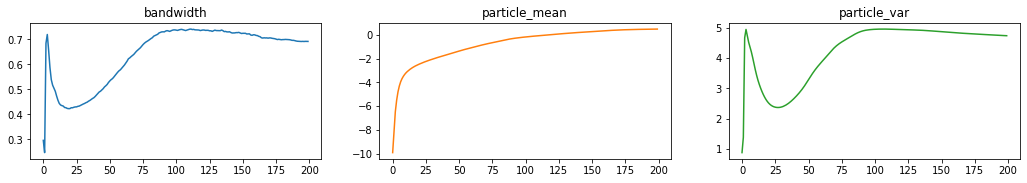

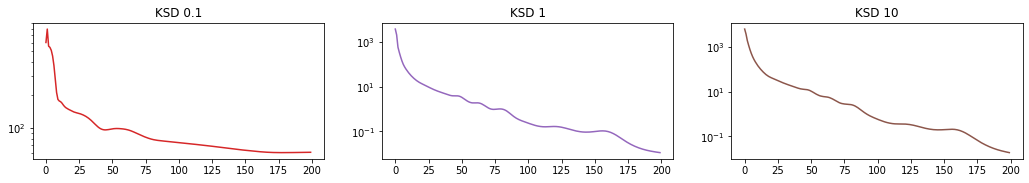

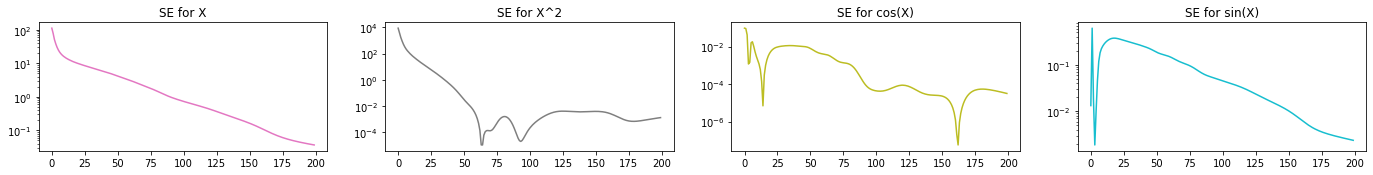

In [11]:
plot.svgd_log(log12)

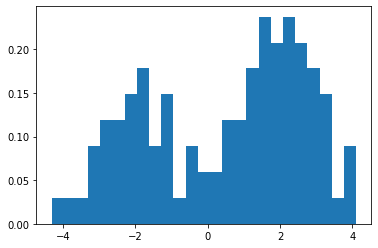

In [12]:
_ = plt.hist(xout12[:, 0], density=True, bins=25)

Comparison to true random sample:

In [ ]:
rkey = random.PRNGKey(0)
rkeys = random.split(rkey)
ntest = 100
x1 = random.normal(rkeys[0], shape=(ntest // 3,1)) - 2
x2 = random.normal(rkeys[1], shape=(ntest * 2 // 3,1)) + 2
xtest = np.concatenate([x1, x2])

_ = plt.hist(xtest[:, 0], density=True, bins=25)

## Experiment 1.3: fixed bandwidth
Again one dimension, but this time fix the bandwidth.

In [ ]:
dist13 = metrics.GaussianMixture([-2, 2], [1, 1], [1/3, 2/3])

In [ ]:
# experiment:
n = 100
d = 1
stepsize = 0.01
L = 1000

svgd_fix13 = SVGD(dist13, n_iter_max=L, adaptive_kernel=False, get_bandwidth=None, particle_shape=(n, d))

In [ ]:
h = 1
n_iter = L
svgd_fix13.newkey()
st = time.time()
xout13, log13 = svgd_fix13.svgd(svgd_fix13.rkey, stepsize, bandwidth=h, n_iter=n_iter)
xout13.block_until_ready()
end = time.time()
print(f"Done computing after {end - st} seconds.")

In [ ]:
plot.svgd_log(log13)

Comparison histogram with true random samples:

In [ ]:
_ = plt.hist(xout13[:, 0], density=True, bins=25)

In [ ]:
ntest = 100

rkey = random.split(rkey)[0]
rkeys = random.split(rkey)
x1 = random.normal(rkeys[0], shape=(ntest // 3,1)) - 2
x2 = random.normal(rkeys[1], shape=(ntest * 2 // 3,1)) + 2
xtest = np.concatenate([x1, x2])

# xtest = random.normal(rkey, shape=(ntest, 1))
_ = plt.hist(xtest[:, 0], density=True, bins=25)

# Experiment 2: Multi-dim Gaussian

## Experiment 2.1
Same as before, only now $X$ is $d$-dimensional.
#### Target distribution:
$$ p(x) = \mathcal N(x; \mu, \Sigma), \ \ \ \text { where we take } \mu = (1, \dots, 1)^T \text{ and } \Sigma = I. $$
#### Initialization:
$$ q_0(x) = \mathcal N(x; \mu_0, \Sigma_0), \ \ \ \text{ with } \mu = (-10, \dots, -10) \text{ and } \Sigma = I. $$

#### Kernel:
We'll use a natural generalization of the RBF kernel: $k(x, y) = \exp(-\frac{1}{2} (x - y)^T \sigma^{-1} (x - y))$. The easiest way to adaptively choose the kernel is to let $\Sigma = \text{diag}(h_1, \dots, h_d)$ be diagonal, in which case the kernel is given by $k(x, y) = \exp(-\frac{1}{2} \sum_{k=1}^d \frac{(x_k - y_k)^2}{h_k})$. Then choose the bandwidth parameter
$$ h_k = \text{med}_k^2 / \log n, $$
where med$_k$ is the $k$-th entry in the ($d$-dimensional) median of the $ n \choose 2$ pairwise distances between the points $x_1, \dots, x_n$.

In [ ]:
dist21 = metrics.Gaussian([0, 0], [1, 1])

In [ ]:
n = 100
d = 2
stepsize = 0.01
L = int(3 / stepsize)

svgd_adaptive21 = SVGD(dist21, n_iter_max=L, adaptive_kernel=True, get_bandwidth=get_bandwidth, particle_shape=(n, d))

In [ ]:
xout21, log21 = svgd_adaptive21.svgd(svgd_adaptive21.rkey, stepsize, bandwidth=0, n_iter=L)
xout21.block_until_ready()
print()

### Diagnostics

In [ ]:
plot.svgd_log(log21)

In [ ]:
plot.bivariate_hist(xout21)

In [ ]:
rkey = random.PRNGKey(0)
mean21 = np.array([0, 0])
cov21 = np.array([[1, 0], [0, 1]])
xtest = random.multivariate_normal(rkey, mean21, cov21, shape=(100,))

plot.bivariate_hist(xtest)

Comparison histogram:

## Experiment 2.2:
Multivariate normal target function with non-diagonal covariance.

In [ ]:
mean = np.array([1,2])
cov = np.array([[1,1], [1, 2]])

dist22 = metrics.Gaussian(mean, cov)

In [ ]:
n = 100
d = 2
stepsize = 0.01
L = int(3 / stepsize)

svgd_adaptive22 = SVGD(dist22, n_iter_max=L, adaptive_kernel=True, get_bandwidth=get_bandwidth, particle_shape=(n, d))

In [ ]:
xout22, log22 = svgd_adaptive22.svgd(svgd_adaptive22.rkey, stepsize, bandwidth=0, n_iter=L)
xout22.block_until_ready()
print()

In [ ]:
plot.svgd_log(log22)

In [ ]:
plot.bivariate_hist(xout22)

Comparison histogram:

In [ ]:
rkey = random.PRNGKey(0)
xtest = random.multivariate_normal(rkey, mean, cov, shape=(10000,))

print("mean", np.mean(xtest, axis=0) - mean)
print("var", np.var(xtest, axis=0) - var)

plot.bivariate_hist(xtest)

## Experiment 2.3: fixed bandwidth

In [ ]:
mean = np.array([1,2])
cov = np.array([[1,1], [1, 2]])
dist23 = metrics.Gaussian(mean, cov)

In [ ]:
n = 100
d = 2
stepsize = 0.01
L = int(3 / stepsize)

svgd_fix23 = SVGD(dist23, n_iter_max=L, particle_shape=(n, d))

In [ ]:
h = 1
xout23, log23 = svgd_fix23.svgd(svgd_fix23.rkey, stepsize, bandwidth=h, n_iter=L)
xout23.block_until_ready()
print()

In [ ]:
plot.svgd_log(log23)

In [ ]:
plot.bivariate_hist(xout23)

Comparison histogram:

In [ ]:
rkey = random.PRNGKey(0)
xtest = random.multivariate_normal(rkey, mean, cov, shape=(100,))

plot.bivariate_hist(xtest)

# Experiment 3: Bayesian logistic regression

In [ ]:
# number of samples
n = 500

First, $\alpha \sim \text{Gamma}(a, b)$.

In [ ]:
from jax.scipy.stats import gamma

# Generate regression parameters
a = 2 # shape
# b = 1 # rate parameter (1 / scale)

key = random.PRNGKey(0)
gamma_samples = random.gamma(key, a, shape=(1000,))

count, bins, ignored = plt.hist(gamma_samples, bins = 100, density=True)
y = gamma.pdf(bins, a)
_ = plt.plot(bins, y, 'r')

In [ ]:
_ = plt.plot(bins, 1 / y)

In [ ]:
key = random.PRNGKey(0)
alpha = random.gamma(key, a, shape=(1,))

In [ ]:
print(alpha)

Now, $p(\beta \ \vert \alpha) = \mathcal N (\beta;\ 0, \alpha^{-1})$.

In [ ]:
beta = random.normal(key, shape=(2,)) * 1 / np.sqrt(alpha)

Finally, $\log \frac{\pi_i}{1 - \pi_i} = \beta_0 + \beta_1 X_i$. In other words,
$$ \pi_i = \frac{\text{exp}(\beta_0 + \beta_1 X_i)}{1 - \text{exp}(\beta_0 + \beta_1 X_i)}.$$

In [ ]:
x = np.linspace(start=-10, stop=10, num=n)
pi = np.exp(beta[0] + beta[1] * x / (1 - np.exp(beta[0] + beta[1] * x)))

We can now sample the $Y_i$, which are distributed as
$$Y_i \ \vert X_i \sim \text{Bernoulli}(\pi_i).$$

In [ ]:
y = random.bernoulli(key, p=pi, shape=(n,))

### Bayesian inference
We now have a set of observations $\{(y_i, x_i)\}_{i=1, \dots, n}$, (that is, `x` and `y`) and a prior $p(\beta_0, \beta_1)$ over the logistic regression parameters.

The prior is given as follows. Choose $\beta_0, \beta_1$ to be independently identically distributed as 
$$p(\beta) = p(\beta \vert \alpha) \ p(\alpha),$$
where 
\begin{align}   
    p(\beta \vert \alpha) &= \mathcal N(\beta; 0, \alpha^{-1}) \\
    p(\alpha) &= \text{Gamma}(\alpha; a, b),
\end{align}
and $a, b$ are fixed parameters.



Then the posterior is given by
\begin{equation}
    p(\beta_0, \beta_1 \vert x, y) \propto p(y \vert x; \beta_0, \beta_1) p(\beta_0, \beta_1).
\end{equation}

This posterior is the target distribution for SVGD.

In [ ]:
from jax.scipy.stats import norm, gamma

In [ ]:
def p(beta, alpha, x, y, a, b):
    """
    IN:
    * beta: np array w/ shape (2,), regression parameters
    * alpha: scalar > 0, precision parameter for beta prior
    * x: np array of shape (n,)
    * y: np array of shape (n,) and type bool (bernoulli sample)
    * a, b: scalars > 0, parameters for gamma prior on alpha
    
    OUT:
    * scalar, unnormalized posterior pdf evaluated at beta and alpha: p(beta, alpha | x, y, a, b)
    """
    assert beta.shape[0] == 2
    pi = np.exp(beta[0] + beta[1] * x) / (1 - np.exp(beta[0] + beta[1] * x))
    
    p1 = pi * y + (1 - pi) * (1 - y)
    p1 = np.prod(p1) # likelihood of all x's
    p2 = np.prod(norm.pdf(beta, loc=0, scale=1/alpha))
    p3 = gamma.pdf(alpha, a)
    
    return p1 * p2 * p3

In [ ]:
pb = vmap(p, in_axes=(0, None, None, None, None, None))
pbb = vmap(pb, in_axes=(0, None, None, None, None, None))

In [ ]:
def logp(beta, alpha, x, y, a, b):
    """
    IN:
    * beta: np array w/ shape (2,), regression parameters
    * alpha: scalar > 0, precision parameter for beta prior
    * x: np array of shape (n,)
    * y: np array of shape (n,) and type bool (bernoulli sample)
    * a, b: scalars > 0, parameters for gamma prior on alpha
    
    OUT:
    * scalar, unnormalized posterior pdf evaluated at beta and alpha: p(beta, alpha | x, y, a, b)
    """
    assert beta.shape[0] == 2
    
    log_pi = beta[0] + beta[1] * x - np.log(1 + np.exp(beta[0] + beta[1] * x)) # array of length n
    one_minus_log_pi = np.log(1 + np.exp(beta[0] + beta[1] * x)) # array of length n
    
    log_p1 = y * log_pi + (1 - y) * one_minus_log_pi # array of length n
    log_p1 = np.sum(log_p1) # scalar
    
    log_p2 = np.sum(norm.logpdf(beta, loc=0, scale=1/alpha))
    log_p3 = gamma.logpdf(alpha, a)
    
    return log_p1 + log_p2 + log_p3

In [ ]:
logpb = vmap(logp, in_axes=(0, None, None, None, None, None))
logpbb = vmap(logpb, in_axes=(0, None, None, None, None, None))

### quick 3d plot of beta

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [ ]:
# make data
num = 60
X = np.linspace(-7, 7, num)
Y = np.linspace(-7, 7, num)
X, Y = np.meshgrid(X, Y) # both shape (40, 40)
bet = np.array(list(zip(X, Y))).reshape(num, num, 2)

b = np.array(1)
print(logpbb(bet, alpha, x, y, a, b).shape)

Z = logpbb(bet, alpha, x, y, a, b)
Z = np.squeeze(Z)

In [ ]:
1 / alpha

In [ ]:
# plot
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.xlabel("beta_0")
plt.ylabel("beta_1")
ax.set_zlabel("p(beta_0, beta_1, alpha)")

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)